In [1]:
# import models and solvers
from centroidal_plus_double_integrator_kinematics_acados_solver import CentroidalPlusLegKinematicsAcadosSolver
from centroidal_plus_double_integrator_kinematics_casadi_model  import CentroidalPlusLegKinematicsCasadiModel
import conf_solo12_bound_step_adjustment_full_kinematics_mpc as conf
from robot_properties_solo.solo12wrapper import Solo12Config
from wholebody_croccodyl_solver import WholeBodyDDPSolver
from wholebody_croccodyl_model import WholeBodyModel
import pinocchio as pin
import numpy as np
import utils
import sys

# DDP warm-start
wbd_model = WholeBodyModel(conf)
ddp_planner = WholeBodyDDPSolver(wbd_model, MPC=False, WARM_START=False)
ddp_planner.solve()
ddp_sol = ddp_planner.get_solution_trajectories()
centroidal_warmstart = ddp_sol['centroidal']
q_warmstart = ddp_sol['jointPos']
qdot_warmstart = ddp_sol['jointVel']
x_warmstart = []
u_warmstart = []
rmodel, rdata = conf.rmodel, conf.rdata
for k in range(len(centroidal_warmstart)):
    x_warmstart.append(
        np.concatenate(
            [centroidal_warmstart[k],
             q_warmstart[k], 
             qdot_warmstart[k]]
            )
        )
    u_warmstart.append(np.concatenate([np.zeros(30)]))

# create robot
robot = Solo12Config.buildRobotWrapper()
# load robot in meshcat viewer
viz = pin.visualize.MeshcatVisualizer(
robot.model, robot.collision_model, robot.visual_model)
try:
    viz.initViewer(open=True)
except ImportError as err:
    print(err)
    sys.exit(0)
viz.loadViewerModel()
# add contact surfaces
s = 0.5*conf.step_adjustment_bound
for i, contacts in enumerate(conf.contact_sequence):
    for contact_idx, contact in enumerate(contacts):
        if contact.ACTIVE:
            t = contact.pose.translation
            # debris box
            if contact.CONTACT == 'FR' or contact.CONTACT == 'FL':
                utils.addViewerBox(
                    viz, 'world/debris'+str(i)+str(contact_idx), 
                    2*s, 2*s, 0., [1., .2, .2, .5]
                    )
            if contact.CONTACT == 'HR' or contact.CONTACT == 'HL':
                utils.addViewerBox(
                    viz, 'world/debris'+str(i)+str(contact_idx),
                    2*s, 2*s, 0., [.2, .2, 1., .5]
                    )
            utils.applyViewerConfiguration(
                viz, 'world/debris'+str(i)+str(contact_idx), 
                [t[0], t[1], t[2]-0.017, 1, 0, 0, 0]
                )
            utils.applyViewerConfiguration(
                viz, 'world/debris_center'+str(i)+str(contact_idx), 
                [t[0], t[1], t[2]-0.017, 1, 0, 0, 0]
                ) 
# visualize DDP warm-start
for q_warmstart_k in q_warmstart:
    for i in range(10+int(conf.dt/conf.dt_ctrl)):
        viz.display(q_warmstart_k)

# nominal traj-opt
model_nom = CentroidalPlusLegKinematicsCasadiModel(conf, STOCHASTIC_OCP=False)
solver_nom = CentroidalPlusLegKinematicsAcadosSolver(
    model_nom, x_warmstart, u_warmstart, MPC=True
)
x_nom, u_nom, lqr_gains = solver_nom.solve()

# stochastic traj-opt
model_stoch = CentroidalPlusLegKinematicsCasadiModel(conf, STOCHASTIC_OCP=True)
solver_stoch = CentroidalPlusLegKinematicsAcadosSolver(
    model_stoch, x_warmstart, u_warmstart, MPC=True
)
x_stoch, u_stoch, lqr_gains = solver_stoch.solve()

pybullet build time: May 20 2022 19:44:17


Adding Body
"base_link" connected to "world" through joint "floating_base_joint"
joint type: joint FreeFlyer
joint placement:
  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

body info: 
  mass: 1.16115
  lever: 0 0 0
  inertia elements (Ixx,Iyx,Iyy,Izx,Izy,Izz): 0.00578574          0  0.0193811          0          0  0.0247612

Adding Body
"FL_SHOULDER" connected to "base_link" through joint "FL_HAA"
joint type: joint REVOLUTE with axis
joint placement:
  R =
1 0 0
0 1 0
0 0 1
  p = 0.1946 0.0875      0

body info: 
  mass: 0.148538
  lever: -0.078707      0.01         0
  inertia elements (Ixx,Iyx,Iyy,Izx,Izy,Izz):  3.024e-05  4.671e-05 0.00041193          0          0 0.00041107

Adding Body
"FL_UPPER_LEG" connected to "FL_SHOULDER" through joint "FL_HFE"
joint type: joint REVOLUTE with axis
joint placement:
  R =
1 0 0
0 1 0
0 0 1
  p =     0 0.014     0

body info: 
  mass: 0.148538
  lever: 1.377e-05 0.0193585 -0.078707
  inertia elements (Ixx,Iyx,Iyy,Izx,Izy,Izz): 0.00041107          0 0.00

  28  8.60776e+02  1.92227e+06  1.40002e+03  1.00000e-08  1.00000e-08  0.1250  0.00000e+00
  29  6.53929e+02  1.50614e+06  1.25275e+03  1.00000e-08  1.00000e-08  0.5000  0.00000e+00
iter     cost         stop         grad         xreg         ureg       step    ||ffeas||
  30  5.68078e+02  9.05711e+05  8.39974e+02  1.00000e-08  1.00000e-08  0.2500  0.00000e+00
  31  5.21037e+02  5.82581e+05  6.68993e+02  1.00000e-08  1.00000e-08  0.2500  0.00000e+00
  32  3.47300e+02  3.39072e+05  5.74135e+02  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
  33  3.47300e+02  2.94232e+04  2.46322e+02  1.00000e-08  1.00000e-08  0.0020  0.00000e+00
  34  3.47300e+02  2.94219e+04  2.46319e+02  1.00000e-07  1.00000e-07  0.0020  0.00000e+00
  35  3.47300e+02  2.94081e+04  2.46297e+02  1.00000e-06  1.00000e-06  0.0020  0.00000e+00
  36  3.47300e+02  2.92790e+04  2.46089e+02  1.00000e-05  1.00000e-05  0.0020  0.00000e+00
  37  3.47300e+02  2.84484e+04  2.44746e+02  1.00000e-04  1.00000e-04  0.0020  0.00000e+00


rm -f libacados_ocp_solver_quadruped_centroidal_momentum_plus_leg_kinematics.so
rm -f quadruped_centroidal_momentum_plus_leg_kinematics_constraints/quadruped_centroidal_momentum_plus_leg_kinematics_constr_h_fun_jac_uxt_zt.o quadruped_centroidal_momentum_plus_leg_kinematics_constraints/quadruped_centroidal_momentum_plus_leg_kinematics_constr_h_fun.o acados_solver_quadruped_centroidal_momentum_plus_leg_kinematics.o
cc -fPIC -std=c99   -O2 -I/home/agazar/devel/workspace/src/acados/include -I/home/agazar/devel/workspace/src/acados/include/acados -I/home/agazar/devel/workspace/src/acados/include/blasfeo/include -I/home/agazar/devel/workspace/src/acados/include/hpipm/include  -c -o quadruped_centroidal_momentum_plus_leg_kinematics_constraints/quadruped_centroidal_momentum_plus_leg_kinematics_constr_h_fun_jac_uxt_zt.o quadruped_centroidal_momentum_plus_leg_kinematics_constraints/quadruped_centroidal_momentum_plus_leg_kinematics_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/agazar/

RTI preparation phase took 0.006685733795166016 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.0531466007232666 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05983233451843262  seconds

MPC Iteration 11
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.0045623779296875 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05440330505371094 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05896568298339844  seconds

MPC Iteration 12
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.004613161087036133 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05312800407409668 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05774116516113281  seconds

MPC Iteration 13
--------------------------------------------------
starti

RTI preparation phase took 0.006346702575683594 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05357170104980469 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05991840362548828  seconds

MPC Iteration 32
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.00878596305847168 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.06607866287231445 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.07486462593078613  seconds

MPC Iteration 33
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.01065826416015625 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.06389331817626953 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.07455158233642578  seconds

MPC Iteration 34
--------------------------------------------------
start

RTI preparation phase took 0.00641179084777832 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05301785469055176 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05942964553833008  seconds

MPC Iteration 53
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.005125761032104492 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05399942398071289 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05912518501281738  seconds

MPC Iteration 54
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.005071878433227539 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05309128761291504 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05816316604614258  seconds

MPC Iteration 55
--------------------------------------------------
star

starting RTI preparation phase ...
RTI preparation phase took 0.004534721374511719 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.051671743392944336 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.056206464767456055  seconds

MPC Iteration 74
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.004786491394042969 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.0541234016418457 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05890989303588867  seconds

MPC Iteration 75
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.008441686630249023 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05159401893615723 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.06003570556640625  seconds

MPC Iteration 76
------------------

RTI preparation phase took 0.009379863739013672 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.0564420223236084 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.06582188606262207  seconds

MPC Iteration 95
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.0044667720794677734 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05207085609436035 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.056537628173828125  seconds

MPC Iteration 96
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.004520416259765625 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05591750144958496 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.060437917709350586  seconds

MPC Iteration 97
--------------------------------------------------
s

RTI preparation phase took 0.006391763687133789 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05094742774963379 seconds

iter	qp_stat	qp_iter
0	0	0
1	0	14


HOORAY ! found a solution after : 0.05733919143676758  seconds

MPC Iteration 116
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.004575967788696289 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05324268341064453 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05781865119934082  seconds

MPC Iteration 117
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.004476785659790039 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05250358581542969 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.05698037147521973  seconds

MPC Iteration 118
--------------------------------------------------


starting RTI preparation phase ...
RTI preparation phase took 0.004515886306762695 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.04816174507141113 seconds

iter	qp_stat	qp_iter
0	0	0
1	0	14


HOORAY ! found a solution after : 0.05267763137817383  seconds

MPC Iteration 137
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.0044956207275390625 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.04930424690246582 seconds

iter	qp_stat	qp_iter
0	0	0
1	0	14


HOORAY ! found a solution after : 0.05379986763000488  seconds

MPC Iteration 138
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.004528522491455078 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.04833197593688965 seconds

iter	qp_stat	qp_iter
0	0	0
1	0	14


HOORAY ! found a solution after : 0.05286049842834473  seconds

MPC Iteration 139
---------------

RTI preparation phase took 0.006717681884765625 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05231475830078125 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.059032440185546875  seconds

MPC Iteration 158
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.017879962921142578 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.1506361961364746 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.1685161590576172  seconds

MPC Iteration 159
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.006325960159301758 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.05443739891052246 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.06076335906982422  seconds

MPC Iteration 160
--------------------------------------------------
s

rm -f libacados_ocp_solver_quadruped_centroidal_momentum_plus_leg_kinematics.so
rm -f quadruped_centroidal_momentum_plus_leg_kinematics_constraints/quadruped_centroidal_momentum_plus_leg_kinematics_constr_h_fun_jac_uxt_zt.o quadruped_centroidal_momentum_plus_leg_kinematics_constraints/quadruped_centroidal_momentum_plus_leg_kinematics_constr_h_fun.o acados_solver_quadruped_centroidal_momentum_plus_leg_kinematics.o
cc -fPIC -std=c99   -O2 -I/home/agazar/devel/workspace/src/acados/include -I/home/agazar/devel/workspace/src/acados/include/acados -I/home/agazar/devel/workspace/src/acados/include/blasfeo/include -I/home/agazar/devel/workspace/src/acados/include/hpipm/include  -c -o quadruped_centroidal_momentum_plus_leg_kinematics_constraints/quadruped_centroidal_momentum_plus_leg_kinematics_constr_h_fun_jac_uxt_zt.o quadruped_centroidal_momentum_plus_leg_kinematics_constraints/quadruped_centroidal_momentum_plus_leg_kinematics_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/agazar/

starting RTI preparation phase ...
RTI preparation phase took 0.021842479705810547 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.06605863571166992 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.08790111541748047  seconds

MPC Iteration 11
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.021791934967041016 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.06580948829650879 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.0876014232635498  seconds

MPC Iteration 12
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.02170419692993164 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07030916213989258 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09201335906982422  seconds

MPC Iteration 13
---------------------

starting RTI preparation phase ...
RTI preparation phase took 0.04422330856323242 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07666850090026855 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.12089180946350098  seconds

MPC Iteration 32
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.02891850471496582 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.08144164085388184 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.11036014556884766  seconds

MPC Iteration 33
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.02615642547607422 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07268333435058594 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09883975982666016  seconds

MPC Iteration 34
----------------------

starting RTI preparation phase ...
RTI preparation phase took 0.023180723190307617 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07013106346130371 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09331178665161133  seconds

MPC Iteration 53
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.02320098876953125 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.06967616081237793 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09287714958190918  seconds

MPC Iteration 54
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.02322864532470703 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07024955749511719 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09347820281982422  seconds

MPC Iteration 55
---------------------

starting RTI preparation phase ...
RTI preparation phase took 0.023609638214111328 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07750892639160156 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.10111856460571289  seconds

MPC Iteration 74
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.02360248565673828 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07223844528198242 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.0958409309387207  seconds

MPC Iteration 75
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.029384374618530273 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07949352264404297 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.10887789726257324  seconds

MPC Iteration 76
---------------------

starting RTI preparation phase ...
RTI preparation phase took 0.02430582046508789 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07321763038635254 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09752345085144043  seconds

MPC Iteration 95
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.028852224349975586 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.1109933853149414 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.139845609664917  seconds

MPC Iteration 96
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.032212018966674805 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07918548583984375 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.11139750480651855  seconds

MPC Iteration 97
-----------------------

starting RTI preparation phase ...
RTI preparation phase took 0.022751569747924805 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07231402397155762 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09506559371948242  seconds

MPC Iteration 116
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.02265024185180664 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07116127014160156 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.0938115119934082  seconds

MPC Iteration 117
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.026082754135131836 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07672739028930664 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.10281014442443848  seconds

MPC Iteration 118
------------------

starting RTI preparation phase ...
RTI preparation phase took 0.02368640899658203 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07187724113464355 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09556365013122559  seconds

MPC Iteration 137
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.023663997650146484 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07166314125061035 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09532713890075684  seconds

MPC Iteration 138
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.023595571517944336 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07205438613891602 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09564995765686035  seconds

MPC Iteration 139
-----------------

starting RTI preparation phase ...
RTI preparation phase took 0.023435354232788086 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07119178771972656 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.09462714195251465  seconds

MPC Iteration 158
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.02375507354736328 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07127690315246582 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.0950319766998291  seconds

MPC Iteration 159
--------------------------------------------------
starting RTI preparation phase ...
RTI preparation phase took 0.024367332458496094 seconds
starting RTI feedback phase ...
RTI feedback phase took 0.07569384574890137 seconds

iter	qp_stat	qp_iter
0	0	0
1	2	15


HOORAY ! found a solution after : 0.10006117820739746  seconds

MPC Iteration 160
------------------

In [6]:
from centroidal_plus_double_integrator_kinematics_acados_simulator import CentroidalPlusLegKinematicsAcadosSimulator
# run monte-carlo simulations
nb_sims = 100
simulator_nom = CentroidalPlusLegKinematicsAcadosSimulator(model_nom, solver_nom)
# sample addtitive disturbances and pass them to both simulators
w_total = np.zeros((nb_sims, conf.N-1, x_nom.shape[1]))
for sim in range(nb_sims):
    for time_idx in range(conf.N-1):
        w_total[sim, time_idx, :] = simulator_nom.sample_addtitive_uncertainties() 

# simulate nominal MPC
x_sim_nom = simulator_nom.simulate(x_nom[0, :], u_nom, lqr_gains, np.copy(w_total), nb_sims=nb_sims, WITH_DISTURBANCES=True)
violations_nom, ee_positions_nom = simulator_nom.count_constraint_violations(x_sim_nom, WITH_VISUALIZATION=False)
print("number of contact location constraint violations for nominal MPC :", violations_nom)

# simulate stochastic MPC
simulator_stoch = CentroidalPlusLegKinematicsAcadosSimulator(model_stoch, solver_stoch)
x_sim_stoch = simulator_stoch.simulate(x_stoch[0, :], u_stoch, lqr_gains, np.copy(w_total), nb_sims=nb_sims, WITH_DISTURBANCES=True)
violations_stoch, ee_positions_stoch = simulator_stoch.count_constraint_violations(x_sim_stoch, WITH_VISUALIZATION=False)
print("number of contact location constraint violations for stochastic MPC :", violations_stoch)

cc -fPIC -std=c99   -O2 -I/home/agazar/devel/workspace/src/acados/include -I/home/agazar/devel/workspace/src/acados/include/acados -I/home/agazar/devel/workspace/src/acados/include/blasfeo/include -I/home/agazar/devel/workspace/src/acados/include/hpipm/include  -c -o acados_sim_solver_quadruped_centroidal_momentum_plus_leg_kinematics.o acados_sim_solver_quadruped_centroidal_momentum_plus_leg_kinematics.c
cc -fPIC -std=c99   -O2 -I/home/agazar/devel/workspace/src/acados/include -I/home/agazar/devel/workspace/src/acados/include/acados -I/home/agazar/devel/workspace/src/acados/include/blasfeo/include -I/home/agazar/devel/workspace/src/acados/include/hpipm/include  -c -o quadruped_centroidal_momentum_plus_leg_kinematics_model/quadruped_centroidal_momentum_plus_leg_kinematics_expl_ode_fun.o quadruped_centroidal_momentum_plus_leg_kinematics_model/quadruped_centroidal_momentum_plus_leg_kinematics_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/agazar/devel/workspace/src/acados/include -I/home/

starting monte-carlo simulation nb:  93 .....
starting monte-carlo simulation nb:  94 .....
starting monte-carlo simulation nb:  95 .....
starting monte-carlo simulation nb:  96 .....
starting monte-carlo simulation nb:  97 .....
starting monte-carlo simulation nb:  98 .....
starting monte-carlo simulation nb:  99 .....
oh oh ..  FR_FOOT_foot is outside assigned debris at time knot  150
number of contact location constraint violations for nominal MPC : [8, 13, 0, 0]
cc -fPIC -std=c99   -O2 -I/home/agazar/devel/workspace/src/acados/include -I/home/agazar/devel/workspace/src/acados/include/acados -I/home/agazar/devel/workspace/src/acados/include/blasfeo/include -I/home/agazar/devel/workspace/src/acados/include/hpipm/include  -c -o acados_sim_solver_quadruped_centroidal_momentum_plus_leg_kinematics.o acados_sim_solver_quadruped_centroidal_momentum_plus_leg_kinematics.c
cc -fPIC -std=c99   -O2 -I/home/agazar/devel/workspace/src/acados/include -I/home/agazar/devel/workspace/src/acados/inclu

In [7]:
from robot_properties_solo.solo12wrapper import Solo12Config
import pinocchio as pin
import utils

# create robot
robot = Solo12Config.buildRobotWrapper()
# load robot in meshcat viewer
viz = pin.visualize.MeshcatVisualizer(
robot.model, robot.collision_model, robot.visual_model)
try:
    viz.initViewer(open=True)
except ImportError as err:
    print(err)
    sys.exit(0)
viz.loadViewerModel()
# add nominal contact surfaces
s = simulator_nom.debris_half_size
for i, contacts in enumerate(simulator_nom.contact_sequence):
    for contact_idx, contact in enumerate(contacts):
        if contact.ACTIVE:
            t = contact.pose.translation
            # debris box
            if contact.CONTACT == 'FR' or contact.CONTACT == 'FL':
                utils.addViewerBox(
                    viz, 'world/debris'+str(i)+str(contact_idx), 
                    2*s, 2*s, 0., [1., .2, .2, .5]
                    )
            if contact.CONTACT == 'HR' or contact.CONTACT == 'HL':
                utils.addViewerBox(
                    viz, 'world/debris'+str(i)+str(contact_idx),
                    2*s, 2*s, 0., [.2, .2, 1., .5]
                    )
            utils.applyViewerConfiguration(
                viz, 'world/debris'+str(i)+str(contact_idx), 
                [t[0], t[1], t[2]-0.017, 1, 0, 0, 0]
                )
            utils.applyViewerConfiguration(
                viz, 'world/debris_center'+str(i)+str(contact_idx), 
                [t[0], t[1], t[2]-0.017, 1, 0, 0, 0]
                )
                
ee_pos_total_nom = []
ee_pos_total_stoch = []
# visualize end-effector trajectories (TODO: visualize trajectories in mujoco with an army of robots)
for sim in range(nb_sims):
    FL_ee_nom = []
    FR_ee_nom = []
    HL_ee_nom = []
    HR_ee_nom = []
    FL_ee_stoch = []
    FR_ee_stoch = []
    HL_ee_stoch = []
    HR_ee_stoch = []
    for traj_length_nom in range(len(ee_positions_nom[sim])):
        FL_ee_nom += [ee_positions_nom[sim][traj_length_nom][0]]
        FR_ee_nom += [ee_positions_nom[sim][traj_length_nom][1]]
        HL_ee_nom += [ee_positions_nom[sim][traj_length_nom][2]]
        HR_ee_nom += [ee_positions_nom[sim][traj_length_nom][3]]
    for traj_length_stoch in range(len(ee_positions_stoch[sim])):
        FL_ee_stoch += [ee_positions_stoch[sim][traj_length_stoch][0]]
        FR_ee_stoch += [ee_positions_stoch[sim][traj_length_stoch][1]]
        HL_ee_stoch += [ee_positions_stoch[sim][traj_length_stoch][2]]
        HR_ee_stoch += [ee_positions_stoch[sim][traj_length_stoch][3]]
    # plot end-effectors trajectories
    utils.addLineSegment(viz, 'ee_trajectory_nom_FL'+str(sim), np.array(FL_ee_nom).astype(np.float32).T, [1,1,0,1])
    utils.addLineSegment(viz, 'ee_trajectory_nom_FR'+str(sim), np.array(FR_ee_nom).astype(np.float32).T, [1,1,0,1])
    utils.addLineSegment(viz, 'ee_trajectory_nom_HL'+str(sim), np.array(HL_ee_nom).astype(np.float32).T, [1,1,0,1])
    utils.addLineSegment(viz, 'ee_trajectory_nom_HR'+str(sim), np.array(HR_ee_nom).astype(np.float32).T, [1,1,0,1])    
    utils.addLineSegment(viz, 'ee_trajectory_stoch_FL'+str(sim), np.array(FL_ee_stoch).astype(np.float32).T, [1,0,0,1])
    utils.addLineSegment(viz, 'ee_trajectory_stoch_FR'+str(sim), np.array(FR_ee_stoch).astype(np.float32).T, [1,0,0,1])
    utils.addLineSegment(viz, 'ee_trajectory_stoch_HL'+str(sim), np.array(HL_ee_stoch).astype(np.float32).T, [1,0,0,1])
    utils.addLineSegment(viz, 'ee_trajectory_stoch_HR'+str(sim), np.array(HR_ee_stoch).astype(np.float32).T, [1,0,0,1])

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7023/static/


In [4]:
# compute the norm of the difference between the closed-loop contact location and the center of contact surface
contacts_logic_N = simulator_nom.contact_data['contacts_logic']
contacts_position_N = simulator_nom.contact_data['contacts_position'] 
contact_location_nom_total   = [] 
contact_location_stoch_total = [] 
contact_surface_location_nom_total = []
contact_surface_location_stoch_total = []
norm_contact_location_deviation_nom_total = []
norm_contact_location_deviation_stoch_total = []
for sim in range(nb_sims):
    contact_location_nom_per_traj = []
    contact_location_stoch_per_traj = []
    contact_surface_location_nom_per_traj = []
    contact_surface_location_stoch_per_traj = []
    norm_contact_location_deviation_nom_per_traj = []
    norm_contact_location_deviation_stoch_per_traj = []
    for time_idx in range(len(ee_positions_stoch[sim])):
        contact_location_nom_k = []
        contact_location_stoch_k = []
        contact_surface_location_nom_k = []
        contact_surface_location_stoch_k = []
        for contact_idx in range(len(conf.ee_frame_names)):
            # FL
            if contact_idx==0:
                CURR_IN_CONTACT = contacts_logic_N[time_idx][1]
                contact_surface_location_per_foot = contacts_position_N[time_idx][3:6]
            # FR
            elif contact_idx==1:
                CURR_IN_CONTACT = contacts_logic_N[time_idx][0]
                contact_surface_location_per_foot = contacts_position_N[time_idx][0:3]
            # HL
            elif contact_idx==2:
                CURR_IN_CONTACT = contacts_logic_N[time_idx][3]
                contact_surface_location_per_foot = contacts_position_N[time_idx][9:12]
            # HR
            elif contact_idx==3:
                CURR_IN_CONTACT = contacts_logic_N[time_idx][2]
                contact_surface_location_per_foot = contacts_position_N[time_idx][6:9]
            # compute contact location deviation only for the activated contacts
            if CURR_IN_CONTACT:
                contact_surface_location_stoch_k += [contact_surface_location_per_foot]
                contact_location_stoch_k += [ee_positions_stoch[sim][time_idx][contact_idx]]
                if time_idx < len(ee_positions_nom[sim]):
                    contact_surface_location_nom_k += [contact_surface_location_per_foot]
                    contact_location_nom_k += [ee_positions_nom[sim][time_idx][contact_idx]] 
        # since some trajectories fail before resuming till the end in the nominal case
        if time_idx < len(ee_positions_nom[sim]):
            contact_location_nom_per_traj += [contact_location_nom_k]
            contact_surface_location_nom_per_traj += [contact_surface_location_nom_k]
            # compute the contact location at the time of landing
#             if CURR_IN_CONTACT:
            norm_contact_location_deviation_nom_per_traj.append(
                np.linalg.norm(np.asarray(contact_location_nom_k) - np.asarray(contact_surface_location_nom_k))
            )
#             else:
#             norm_contact_location_deviation_nom_per_traj.append(0.)
        contact_location_stoch_per_traj += [contact_location_stoch_k]
        contact_surface_location_stoch_per_traj += [contact_surface_location_stoch_k]
#         if CURR_IN_CONTACT:
        norm_contact_location_deviation_stoch_per_traj.append(
                    np.linalg.norm(np.asarray(contact_location_stoch_k) - np.asarray(contact_surface_location_stoch_k))
                )
#         else:
#         norm_contact_location_deviation_stoch_per_traj.append(0.)
    contact_location_nom_total += [contact_location_nom_per_traj]
    contact_location_stoch_total += [contact_location_stoch_per_traj]
    contact_surface_location_nom_total += [contact_surface_location_nom_per_traj]
    contact_surface_location_stoch_total += [contact_surface_location_stoch_per_traj]
    norm_contact_location_deviation_nom_total += [norm_contact_location_deviation_nom_per_traj]
    norm_contact_location_deviation_stoch_total += [norm_contact_location_deviation_stoch_per_traj]

Text(0.5, 0.98, 'bounding motion')

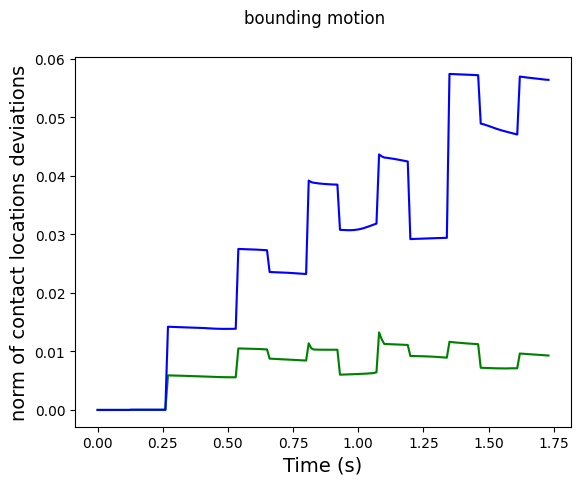

In [5]:
import matplotlib.pylab as plt

# compute statistics
mean_nom_total = np.zeros(conf.N)
std_nom_total = np.zeros(conf.N)
mean_stoch_total = np.zeros(conf.N)
std_stoch_total = np.zeros(conf.N)
for traj_idx in range(conf.N):
    nb_samples_nom = 0.
    nb_samples_stoch = 0.
    samples_nom_k = []
    samples_stoch_k = []
    for sim in range(nb_sims):
        if traj_idx < len(norm_contact_location_deviation_nom_total[sim]):
            mean_nom_total[traj_idx] += norm_contact_location_deviation_nom_total[sim][traj_idx]
            samples_nom_k += [norm_contact_location_deviation_nom_total[sim][traj_idx]]
            nb_samples_nom += 1
        mean_stoch_total[traj_idx] += norm_contact_location_deviation_stoch_total[sim][traj_idx]
        samples_stoch_k += [norm_contact_location_deviation_stoch_total[sim][traj_idx]]
        nb_samples_stoch += 1
    mean_nom_total[traj_idx] = np.mean(samples_nom_k)
    std_nom_total[traj_idx] = np.std(samples_nom_k)
    mean_stoch_total[traj_idx] = np.mean(samples_stoch_k)
    std_stoch_total[traj_idx] = np.std(samples_stoch_k)

# plot the mean over the horizon length 
fig, ax = plt.subplots(1, 1, sharex=True) 
for sim in range(nb_sims):
    time_nom   = np.arange(0, np.round((len(norm_contact_location_deviation_nom_total[sim]))*conf.dt, 2), conf.dt)
    time_stoch = np.arange(0, np.round((len(norm_contact_location_deviation_stoch_total[sim]))*conf.dt, 2), conf.dt)
ax.plot(time_stoch, mean_stoch_total, color='green')
ax.fill_between(time_stoch, mean_stoch_total+2*std_stoch_total, mean_stoch_total-2*std_stoch_total, color='green', alpha=0.1)
ax.plot(time_stoch, mean_nom_total, color='blue')
ax.fill_between(time_stoch, mean_nom_total+2*std_nom_total, mean_nom_total-2*std_nom_total, color='blue', alpha=0.1)
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel('norm of contact locations deviations', fontsize=14)
fig.suptitle('bounding motion')
